<a href="https://colab.research.google.com/github/MurthyKolluru/DBA/blob/main/DBA_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#UMAP
# Install a specific, compatible pair of versions to resolve the conflict.
# umap-learn 0.5.5 is compatible with scikit-learn 1.4.0.
!pip install umap-learn==0.5.5 scikit-learn==1.4.0

# IMPORTANT: You MUST restart the runtime after running this cell.
# Go to the 'Runtime' menu -> 'Restart runtime...'.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


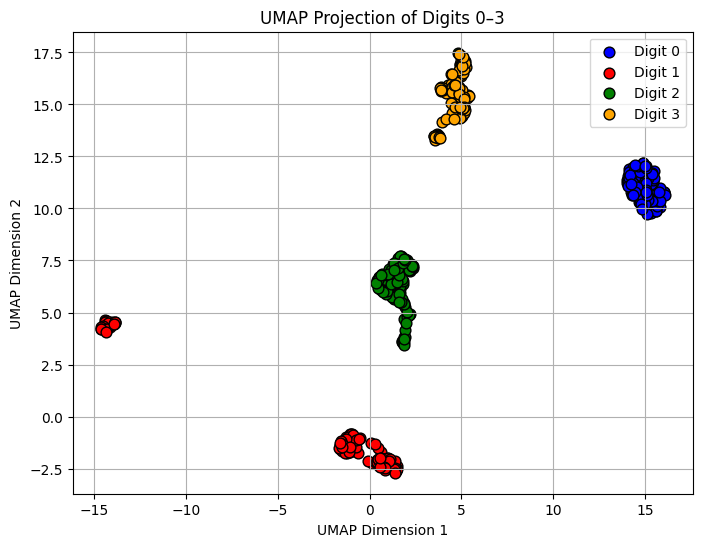

In [ ]:
# Step 2: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import umap

# Step 3: Load digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Step 4: Filter to digits 0, 1, 2, 3
selected_classes = [0, 1, 2, 3]
mask = np.isin(y, selected_classes)
X_filtered = X[mask]
y_filtered = y[mask]

# Step 5: Sample 100 points per class
X_sampled = []
y_sampled = []
samples_per_class = 100

for digit in selected_classes:
    indices = np.where(y_filtered == digit)[0][:samples_per_class]
    X_sampled.append(X_filtered[indices])
    y_sampled.append(y_filtered[indices])

X_sampled = np.vstack(X_sampled)
y_sampled = np.concatenate(y_sampled)

# Step 6: UMAP dimensionality reduction
# This will now work correctly with the compatible library versions.
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_sampled)

# Step 7: Plot the results
color_map = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

plt.figure(figsize=(8, 6))
for class_label in selected_classes:
    idx = y_sampled == class_label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1],
                label=f'Digit {class_label}',
                c=color_map[class_label],
                edgecolors='k',
                s=60)

plt.title('UMAP Projection of Digits 0–3')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

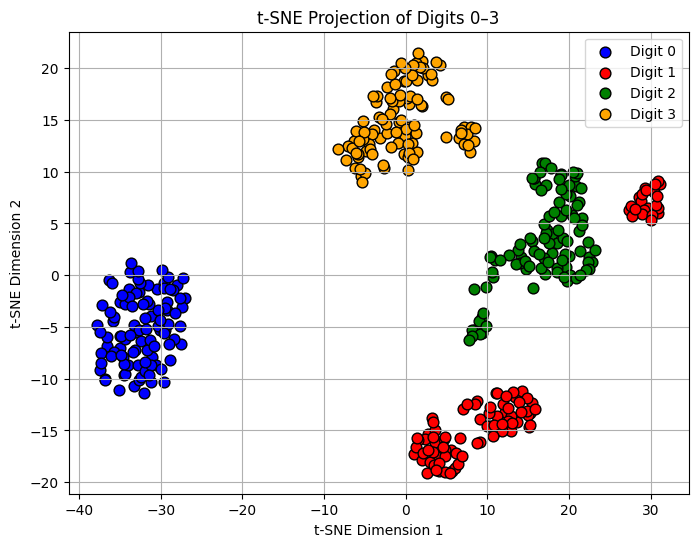

In [ ]:
#T-SNE

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

# Load digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Filter to digits 0, 1, 2, 3
selected_classes = [0, 1, 2, 3]
mask = np.isin(y, selected_classes)
X_filtered = X[mask]
y_filtered = y[mask]

# Sample 100 points per class
X_sampled = []
y_sampled = []
samples_per_class = 100

for digit in selected_classes:
    indices = np.where(y_filtered == digit)[0][:samples_per_class]
    X_sampled.append(X_filtered[indices])
    y_sampled.append(y_filtered[indices])

X_sampled = np.vstack(X_sampled)
y_sampled = np.concatenate(y_sampled)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)

# Plot with custom color map
color_map = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

plt.figure(figsize=(8, 6))
for class_label in selected_classes:
    idx = y_sampled == class_label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                label=f'Digit {class_label}',
                c=color_map[class_label],
                edgecolors='k',
                s=60)

plt.title('t-SNE Projection of Digits 0–3')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


Dataset shape: (20640, 11)
Baseline MSE: 0.25147251200093107


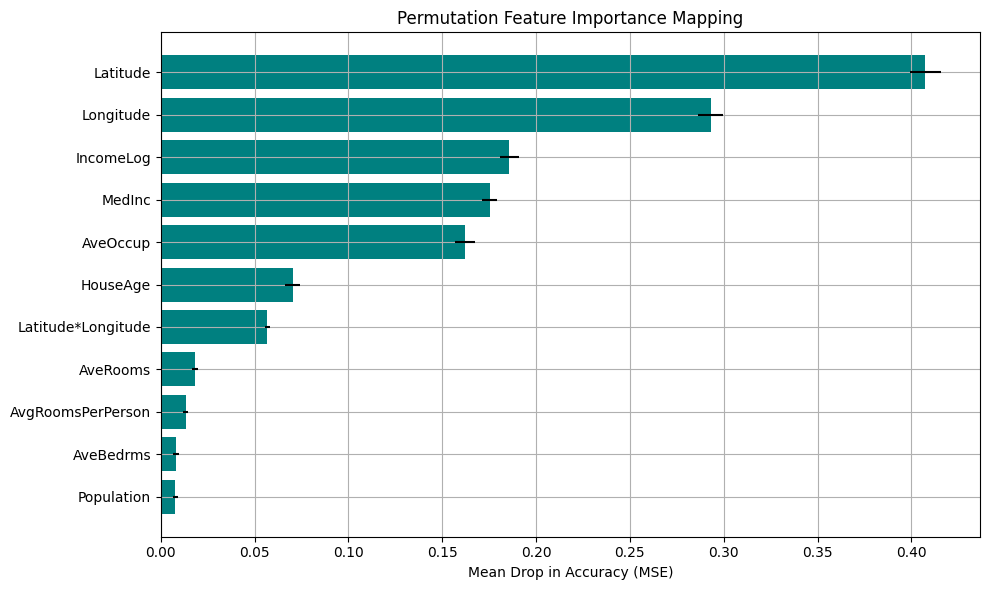

In [ ]:
#Permutation Mapping

# Step 1: Install and import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

# Step 2: Load dataset
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

# Step 3: Add synthetic columns to increase to 12+ features
X["AvgRoomsPerPerson"] = X["AveRooms"] / (X["AveOccup"] + 1)
X["IncomeLog"] = np.log1p(X["MedInc"])
X["Latitude*Longitude"] = X["Latitude"] * X["Longitude"]

# Final shape
print("Dataset shape:", X.shape)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Baseline performance
baseline_mse = mean_squared_error(y_test, model.predict(X_test))
print("Baseline MSE:", baseline_mse)

# Step 7: Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Step 8: Organize and plot
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Step 9: Plot
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'], xerr=importances['Std'], color='teal')
plt.xlabel("Mean Drop in Accuracy (MSE)")
plt.title("Permutation Feature Importance Mapping")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


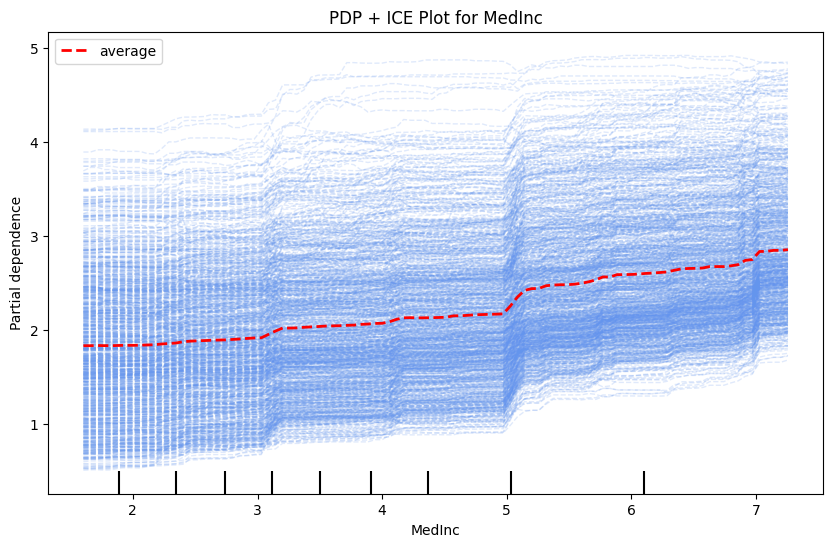

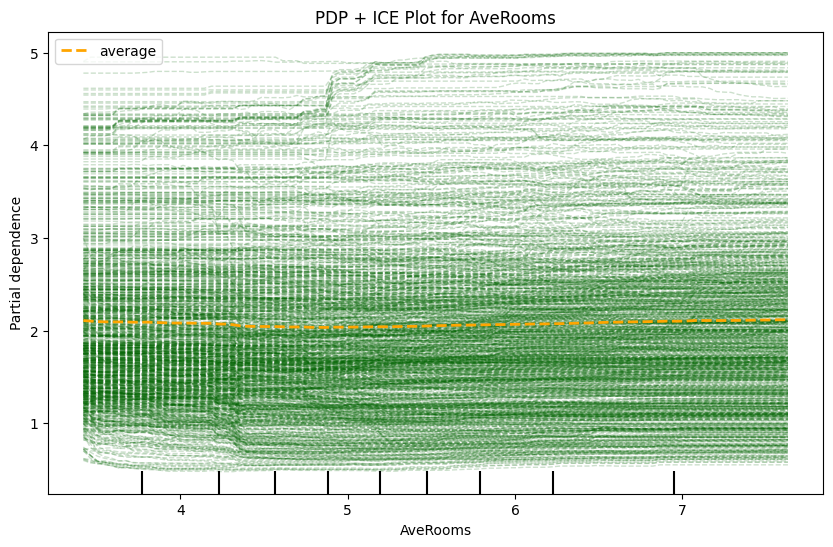

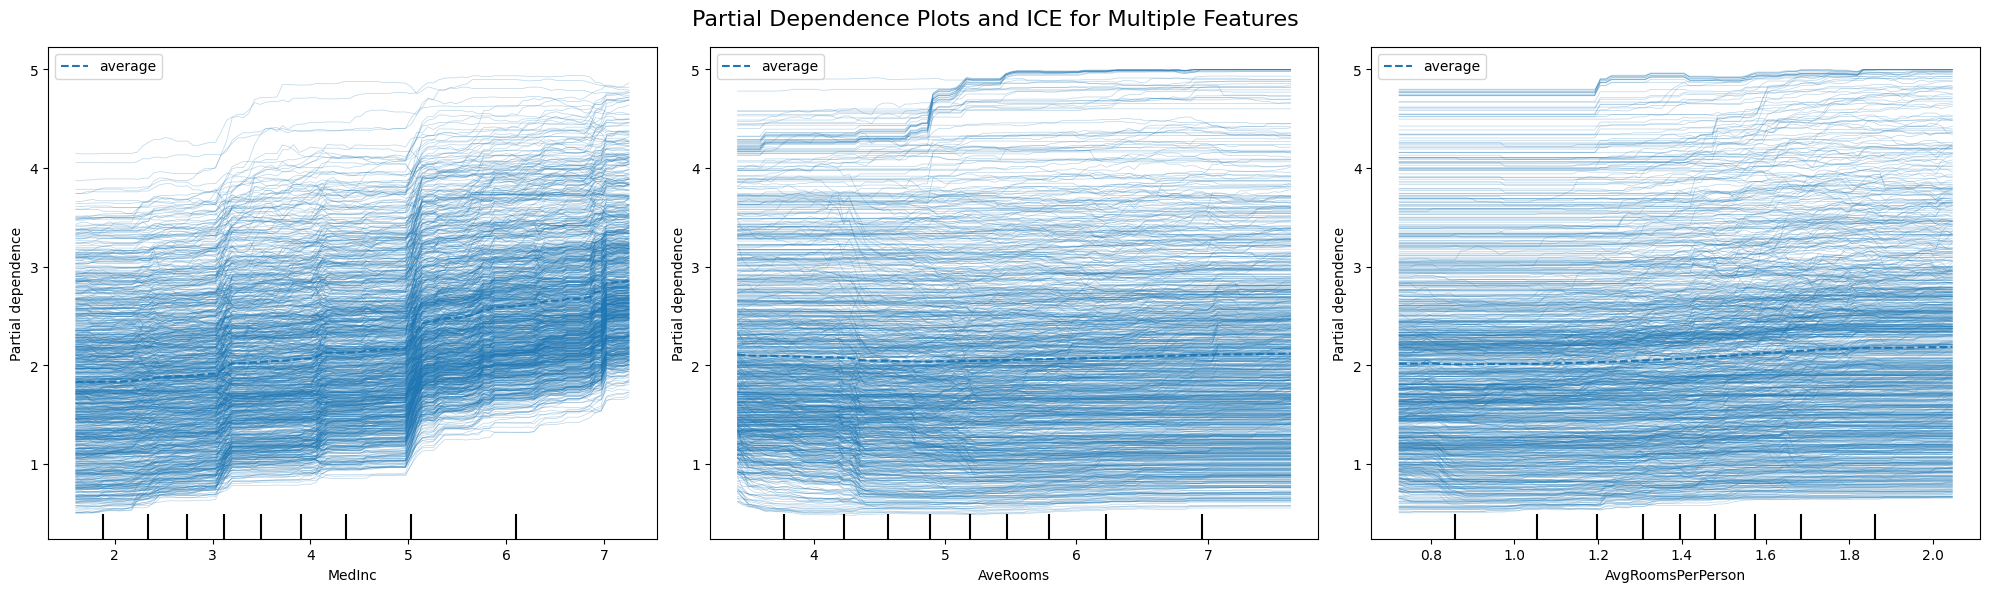

In [ ]:
#PDP and ICE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay

# Step 1: Load and prepare data
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

# Add extra features (optional)
X["AvgRoomsPerPerson"] = X["AveRooms"] / (X["AveOccup"] + 1)
X["IncomeLog"] = np.log1p(X["MedInc"])
X["Latitude*Longitude"] = X["Latitude"] * X["Longitude"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 2: Create Partial Dependency and ICE plots using sklearn.inspection

# PDP + ICE for MedInc
fig, ax = plt.subplots(figsize=(10, 6))
display_medinc = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=['MedInc'],
    kind='both',
    ice_lines_kw={"color": "cornflowerblue", "alpha": 0.2, "linewidth": 1},
    line_kw={"color": "red", "linestyle": "--", "linewidth": 2}, # Corrected parameter name
    ax=ax
)
ax.set_title("PDP + ICE Plot for MedInc")
ax.grid(True)
plt.show()

# PDP + ICE for AveRooms
fig, ax = plt.subplots(figsize=(10, 6))
display_averooms = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=['AveRooms'],
    kind='both',
    ice_lines_kw={"color": "darkgreen", "alpha": 0.2, "linewidth": 1},
    line_kw={"color": "orange", "linestyle": "--", "linewidth": 2}, # Corrected parameter name
    ax=ax
)
ax.set_title("PDP + ICE Plot for AveRooms")
ax.grid(True)
plt.show()

# Optional: Plot multiple features in a single figure
features_to_plot = ['MedInc', 'AveRooms', 'AvgRoomsPerPerson']

fig, ax = plt.subplots(nrows=1, ncols=len(features_to_plot), figsize=(20, 6))

PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=features_to_plot,
    kind='both',
    ax=ax
)
fig.suptitle("Partial Dependence Plots and ICE for Multiple Features", fontsize=16)
plt.tight_layout()
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=47d4952ff8924f983145d4ecd5d5e3cc8777a210e0aa60575a7019cdcdded394
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Intercept 0.6559469079535506
Prediction_local [0.54612905]
Right: 0.94


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Explanation for prediction on instance 5:

('capital-gain <= 0.00', -0.5717861768018192)
('education-num > 12.00', 0.14180118547692694)
('marital-status=2', 0.09511382671056061)
('capital-loss <= 0.00', -0.09368243885432812)
('hours-per-week > 45.00', 0.09353710036048905)
('relationship=0', 0.08795146323031629)
('age > 48.00', 0.06162006243864638)
('occupation=10', 0.039035735718170914)
('sex=1', 0.02728808442377067)
('race=4', 0.009303295998890897)


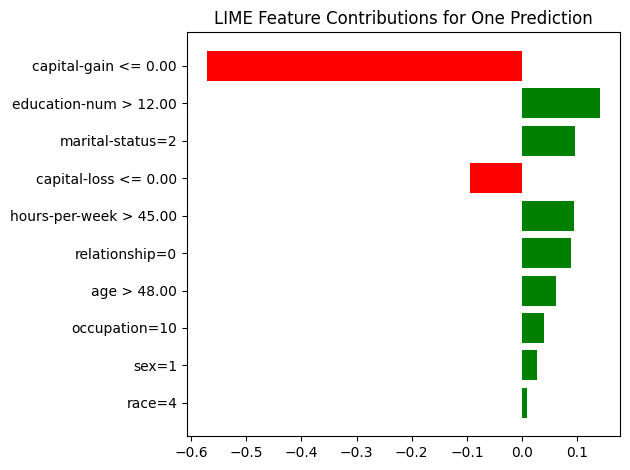

In [ ]:
#LIME

# Step 1: Install LIME
!pip install lime

# Step 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from lime.lime_tabular import LimeTabularExplainer

# Step 3: Load Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)

# Step 4: Encode categorical features
cat_cols = df.select_dtypes(include='object').columns.drop('income')
encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
for col, enc in encoders.items():
    df[col] = enc.transform(df[col])

# Encode target
df['income'] = LabelEncoder().fit_transform(df['income'])

# Step 5: Split and train model
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Set up LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["<=50K", ">50K"],
    categorical_features=[X.columns.get_loc(c) for c in cat_cols],
    discretize_continuous=True,
    verbose=True,
    mode='classification'
)

# Step 7: Explain one instance
i = 5  # you can change this index to explore others
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=model.predict_proba,
    num_features=10
)

# Step 8: Show explanation
exp.show_in_notebook(show_table=True)

# Step 9: Save as HTML (optional)
exp.save_to_file('lime_explanation.html')

# Step 10: Print text explanation
print(f"Explanation for prediction on instance {i}:\n")
print('\n'.join(map(str, exp.as_list())))

# Optional: Plot explanation weights
fig = exp.as_pyplot_figure()
plt.title("LIME Feature Contributions for One Prediction")
plt.tight_layout()
plt.show()


In [ ]:
#SHAP

# Step 1: Downgrade NumPy and install compatible SHAP
!pip install numpy==1.23.5 shap==0.41.0 --force-reinstall


  Using cached shap-0.41.0-cp311-cp311-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.1 MB/s eta 0:00:00
  Using cached slicer-0.0.7-py3-none-any.whl.metadata (3.7 kB)
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.1 MB/s eta 0:00:00
Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.1 MB/s e

In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns.drop('income')
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode the target variable
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Prepare data for model training
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

Generating Beeswarm Plot...


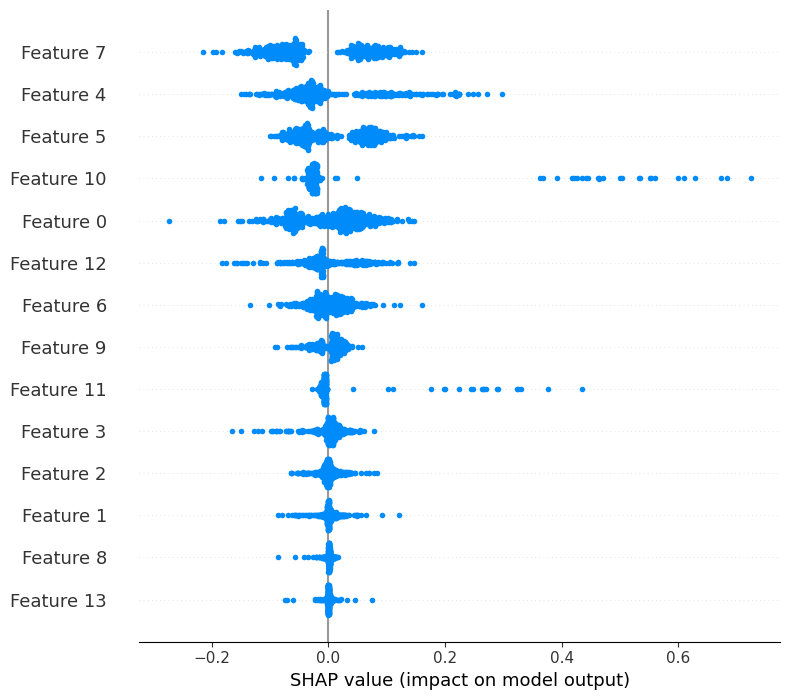

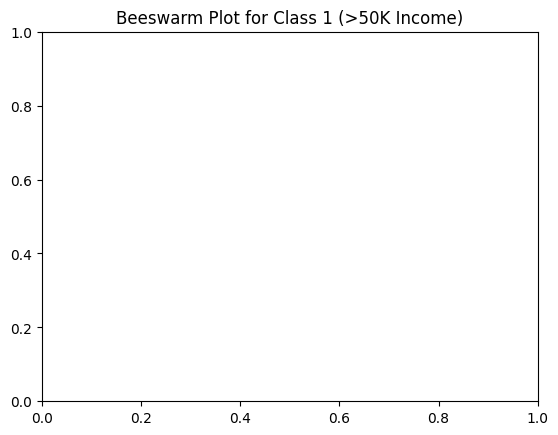

Generating Bar Summary Plot...


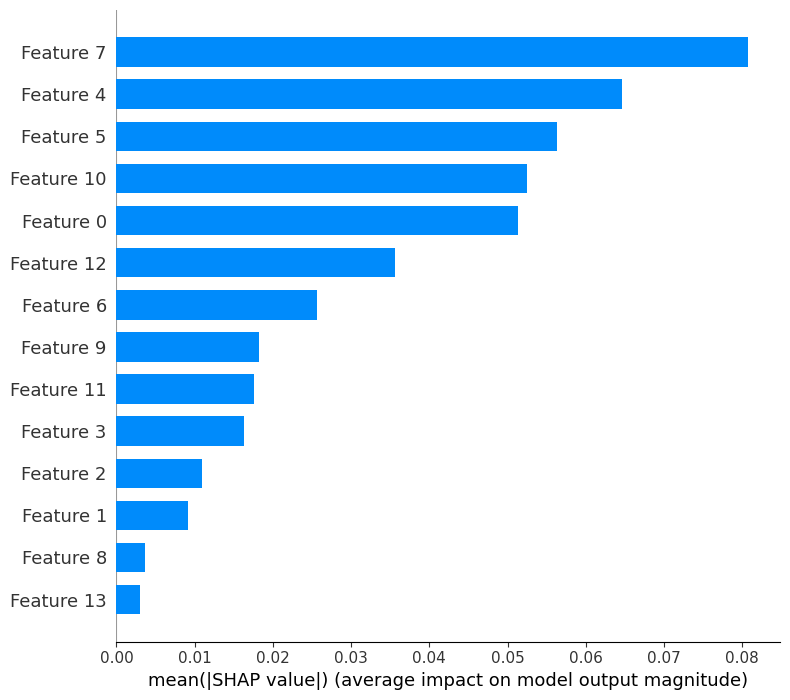

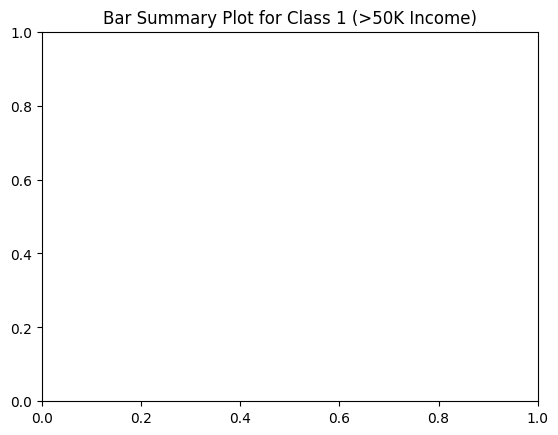

Generating Force Plot for the first prediction...


In [ ]:
# Initialize SHAP and calculate values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test[:500])

# --- SHAP Plots ---

# 1. Beeswarm Plot (Global Feature Importance)
# This plot will now work as it's passed just the shap.Explanation object.
print("Generating Beeswarm Plot...")
plt.figure()
shap.summary_plot(shap_values[1])
plt.title("Beeswarm Plot for Class 1 (>50K Income)")
plt.show()

# 2. Summary Plot (Bar)
print("Generating Bar Summary Plot...")
plt.figure()
shap.summary_plot(shap_values[1], plot_type="bar")
plt.title("Bar Summary Plot for Class 1 (>50K Income)")
plt.show()

# 3. Force Plot (Local Explanation)
print("Generating Force Plot for the first prediction...")
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])